В данном маленьком проекте я бы хотел показать на синтетических данных, почему предсказательная модель (даже интерпретативного плана) может промахнуться в деле causal inference. Я также покажу, ради педагогических целей, эффекты пропущенной переменной и мультиколлинеарности.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

Для начала построим каузальную модель, о которой у нас будут известны ground truth.

**Медиатор Z:**  

X1 -> Z -> Y.

**Спутывающая переменная W:**  

W -> X2,  

W -> X3,  

W -> Y.

**Потенциальный инструмент I:**  

I -> X2.

**И остальные ковариаты:**  

X2 -> Y,  

X3 -> Y.

Построим каузальный граф с помощью networkx...

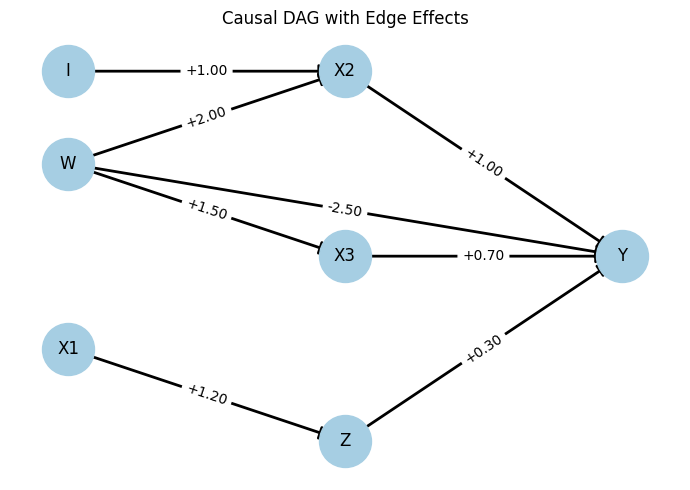

In [2]:
#DAG
# build DAG and positions
G = nx.DiGraph()
edges = [("X1","Z"), ("Z","Y"), ("W","X2"), ("W","X3"), ("W","Y"),
         ("X2","Y"), ("X3","Y"), ("I","X2")]
G.add_edges_from(edges)
pos = {"W":(-1,0), "X1":(-1,-1), "X2":(0,0.5), "I":(-1,0.5),
       "X3":(0,-0.5), "Z":(0,-1.5), "Y":(1, -0.5)}

# attach effect sizes as edge attributes
effects = {
    ("X1","Z"): +1.2,
    ("I","X2"): +1.0,
    ("W","X2"): +2.0,
    ("W","X3"): +1.5,
    ("Z","Y"): +0.3,
    ("W","Y"): -2.5,
    ("X2","Y"): +1.0,
    ("X3","Y"): +0.7
}              

nx.set_edge_attributes(G, effects, name="effect")

# draw nodes and edges
plt.figure(figsize=(7,5))
nx.draw_networkx_nodes(G, pos, node_size=1400, node_color="#a6cee3")
nx.draw_networkx_labels(G, pos, font_size=12)
nx.draw_networkx_edges(G, pos, arrowsize=20, width=2)

# format edge labels with signs
edge_labels = {e: f"{G.edges[e]['effect']:+.2f}" for e in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="k", label_pos=0.5)

plt.title("Causal DAG with Edge Effects")
plt.axis('off')
plt.tight_layout()
plt.show()

Распределения этих узлов:  

W ~ Beta(2.2, 1.2)  
X1 ~ Exp(0.7)  
I ~ Normal (4, 0.8)  
X2 ~ Γ(1.5, 1)  
X3 ~ Uniform (0, 10)  
Z ~ Normal(6.5, 2)  

Направления/значения причинных эффектов обозначены стрелками.

In [3]:
def generate_synthetic(n=10000, seed=0,
                       coef_w_x2=1.0, coef_w_x3=0.8, coef_w_y=0.5,
                       coef_x1_z=1.2, coef_z_y=0.5, coef_x2_y=1.0, coef_x3_y=0.7, coef_i_x2 = 1,
                       noise_scale_x2=0.5, noise_scale_x3=0.5, noise_scale_z=0.5, noise_scale_y=1.0):
    
    rng = np.random.default_rng(seed)

    # Exogenous draws
    W = rng.beta(2.2, 1.2, size=n)
    X1 = rng.exponential(scale=1/0.7, size=n)      # mean = 1/lambda
    Z_exog = rng.normal(loc=6.5, scale=2.0, size=n)
    I_exog = rng.normal(loc=4, scale=0.8, size=n)

    # X2: roughly gamma-shaped by using linear + exp/noise
    eps_x2 = rng.normal(0, noise_scale_x2, size=n)
    X2 = np.maximum(1e-6, coef_i_x2 * I_exog + coef_w_x2 * W + np.exp(0.3 * rng.normal(size=n)) + eps_x2)
    
    # X3: base uniform(0,10) but shift/scale by W to encode W -> X3
    eps_x3 = rng.normal(0, noise_scale_x3, size=n)
    # draw a uniform base, then add dependence on W
    X3_base = rng.uniform(0, 10, size=n)
    X3 = np.clip(X3_base + coef_w_x3 * W + eps_x3, 0, None)

    # Z: depends on X1 plus an exogenous normal component (we keep the prescribed marginal roughly by adding mean)
    eps_z = rng.normal(0, noise_scale_z, size=n)
    Z = Z_exog + coef_x1_z * X1 + eps_z  # Z_exog centers Z near N(6.5,2)

    # strong multicollinear (wrt X2 and X3) variable M for testing purposes
    eps_m = rng.normal(0, 1e-3, size=n)       # tiny noise -> near-perfect collinearity          
    M = 0.33 * X2 + 1.75 * X3 + eps_m         # scale factor 
    
    # Outcome Y: combine direct and mediated effects
    eps_y = rng.normal(0, noise_scale_y, size=n)

    # include W -> Y
    Y = coef_w_y * W + coef_z_y * Z + coef_x2_y * X2 + coef_x3_y * X3 + eps_y

    df = pd.DataFrame({
        "W": W,
        "I": I_exog,
        "X1": X1,
        "X2": X2,
        "X3": X3,
        "Z": Z,
        "M": M,
        "Y": Y
    })
    return df

Сгенерируем 3000 сэмплов сообразно синтетической каузальной модели.

In [4]:
df = generate_synthetic(n=3000, seed=0, coef_w_x2=2, coef_w_x3=1.5, coef_w_y=-2.5, 
                        coef_x1_z=1.2, coef_z_y=0.3, coef_x2_y=1.0, coef_x3_y=0.7, coef_i_x2=1.0,
                        noise_scale_x2=0.2, noise_scale_x3=0.1, noise_scale_z=0.25, noise_scale_y=2)

Узнаем немного о вариации переменных, это потом будет представлять интерес...

In [5]:
print(df.var())

W      0.051639
I      0.624131
X1     1.888322
X2     0.967638
X3     8.603222
Z      6.799590
M     26.589818
Y      9.766609
dtype: float64


Описательная статистика:

In [6]:
df.describe().round(3)

,W,I,X1,X2,X3,Z,M,Y
count,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000,3000.000
mean,0.647,3.991,1.415,6.329,5.959,8.206,12.517,11.314
std,0.227,0.790,1.374,0.984,2.933,2.608,5.157,3.125
min,0.011,1.199,0.000,3.074,0.123,0.455,1.933,1.768
25%,0.482,3.473,0.421,5.652,3.424,6.451,8.061,9.138
50%,0.678,3.993,0.993,6.318,5.949,8.058,12.479,11.345
75%,0.835,4.519,1.951,7.014,8.452,9.778,16.868,13.608
max,0.998,7.122,11.723,10.035,11.475,21.399,22.696,21.664


Гистограммы и матрица корреляций:

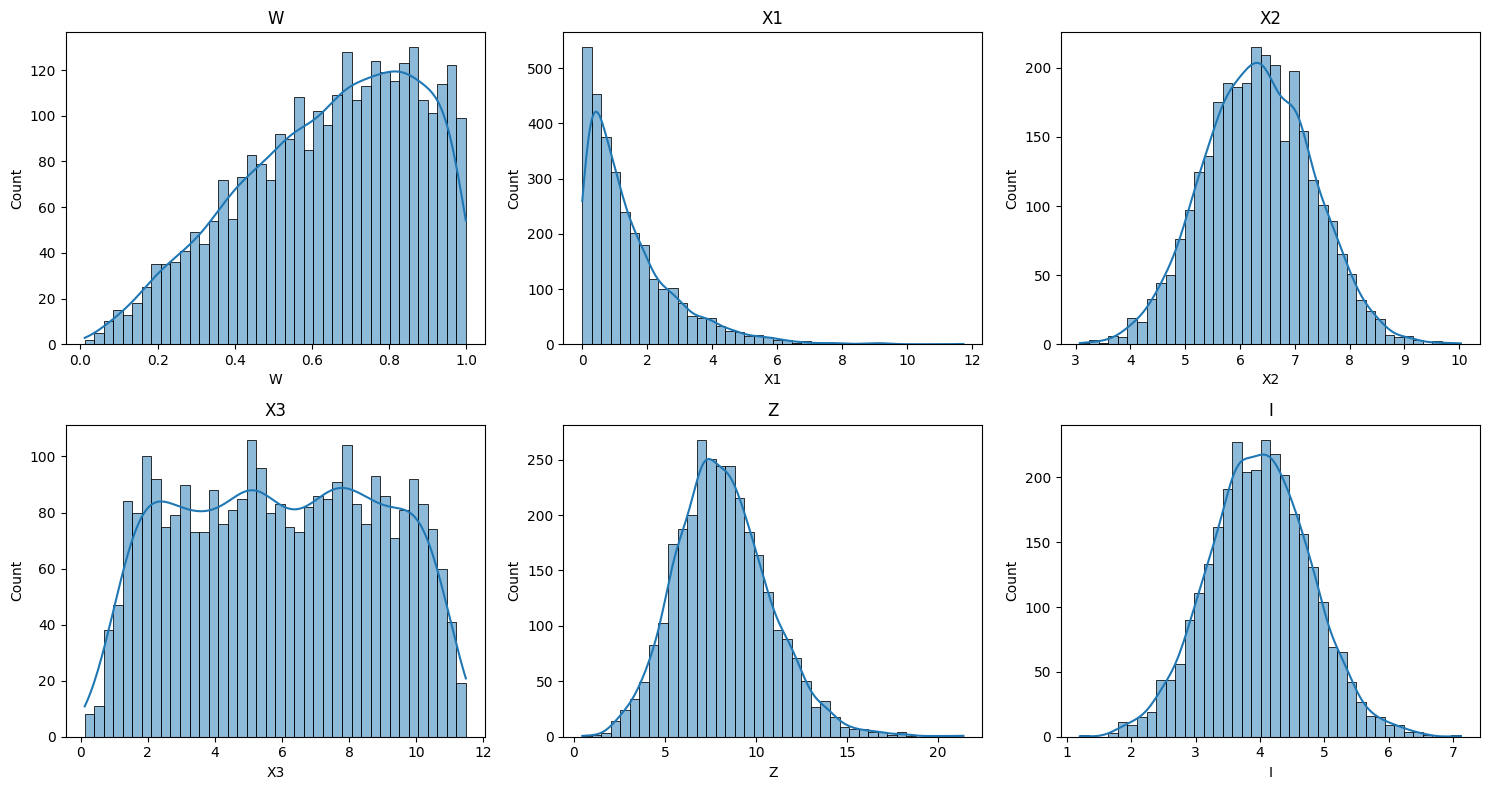

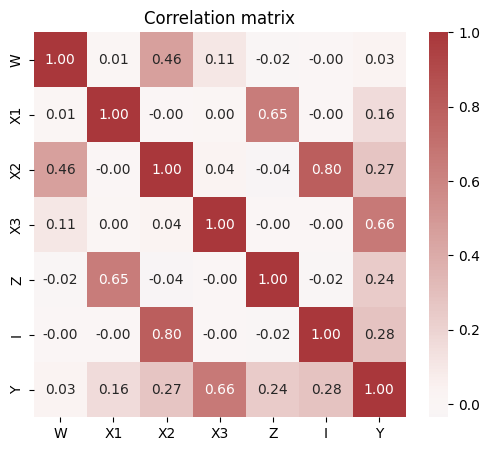

In [7]:
# Univariate distributions (histograms + KDE)
vars = ["W","X1","X2","X3","Z","I", "Y"]
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for ax, col in zip(axes.ravel(), vars):
    sns.histplot(df[col], kde=True, ax=ax, bins=40)
    ax.set_title(col)
plt.tight_layout()
plt.show()

#Correlation Heatmap
corr = df[["W","X1","X2","X3","Z", "I", "Y"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix")
plt.show()

Теперь прогоним через этот синтетический датасет ряд моделей, плохих и хороших.

Но для начала надо оценить, для педагогических целей, эффект пропущенной переменной на наши оценки. На сколько сместится оценка, если мы пропустим в модели W?

Теория гласит, что смещение (OVB) составит:  
$$\text{Bias}(\gamma_1) = \gamma_1 - \beta_1 = \beta_2 \cdot \frac{\text{Cov}(x,z)}{\text{Var}(x)}.$$

Beta2 мы уже знаем. Из графа: она составляет -2.5. 

Осталось оценить Cov(W, X) и Var(X). Ниже:

In [8]:
"""OV Bias Estimation"""
print("\n===OVB ESTIMATION===\n")
ovb_cov_x2 = df["W"].cov(df["X2"])
ovb_cov_x3 = df["W"].cov(df["X3"])
ovb_var_x2 = df["X2"].var()  
ovb_var_x3 = df["X3"].var()  
ovb_bias_x2 = ovb_cov_x2 / ovb_var_x2
ovb_bias_x3 = ovb_cov_x3 / ovb_var_x3
print("Cov(W, X2): ", ovb_cov_x2, "\nCov(W, X3): ", ovb_cov_x3)
print("\nVar(X2): ", ovb_var_x2, "\nVar(X3): ", ovb_var_x3)
print("\nOVB effect on X2: ", -2.5*ovb_bias_x2, "\nOVB effect on X3: ", -2.5*ovb_bias_x3)


===OVB ESTIMATION===

Cov(W, X2):  0.10275830092437716 
Cov(W, X3):  0.07180440967973041

Var(X2):  0.9676381866403536 
Var(X3):  8.603222075574392

OVB effect on X2:  -0.26548740619971467 
OVB effect on X3:  -0.0208655574181887


Мы можем ожидать более сильного эффекта пропущенной переменной (negative bias в -0.26) на X2. Посмотрим на наивную модель (без W и без инструмента):

In [9]:
def ols_summary(df, outcome, predictors):
    X = sm.add_constant(df[predictors])
    model = sm.OLS(df[outcome], X).fit()
    print(f"Model: {outcome} ~ {' + '.join(predictors)}")
    print(model.summary().tables[1])   # coefficient table
    print(f"R-squared: {model.rsquared:.3f}\n")

print("\n===MODEL SPECIFICATIONS===\n")
    
# Naive biased OLS regression
ols_summary(df, "Y", ["X1", "X2", "X3"])


===MODEL SPECIFICATIONS===

Model: Y ~ X1 + X2 + X3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7427      0.269      6.474      0.000       1.215       2.271
X1             0.3613      0.029     12.585      0.000       0.305       0.418
X2             0.7787      0.040     19.403      0.000       0.700       0.857
X3             0.6934      0.013     51.515      0.000       0.667       0.720
R-squared: 0.523



Действительно, X2 должно быть 1.00, но в наивной модели оно оценено в 0.78. Это близко к полученному выше эффекту смещения в -0.26.

Ради интереса посмотрим, что будет, если внести в модель искусственную мультиколлинеарную переменную...

In [10]:
# Naive OLS regression with multicollinearity
ols_summary(df, "Y", ["M", "X1", "X2", "X3"])

Model: Y ~ M + X1 + X2 + X3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7393      0.269      6.459      0.000       1.211       2.267
M            -21.8306     38.478     -0.567      0.571     -97.276      53.615
X1             0.3607      0.029     12.556      0.000       0.304       0.417
X2             7.9833     12.699      0.629      0.530     -16.916      32.882
X3            38.8971     67.336      0.578      0.564     -93.132     170.927
R-squared: 0.523



Просто хаос. Теперь оценим правильную спецификацию, представив, что у нас есть данные о W.

In [11]:
# Full OLS regression (with confounder)
ols_summary(df, "Y", ["W", "X1", "X2", "X3"])

Model: Y ~ W + X1 + X2 + X3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5724      0.261      6.022      0.000       1.060       2.084
W             -2.6665      0.190    -14.008      0.000      -3.040      -2.293
X1             0.3661      0.028     13.162      0.000       0.312       0.421
X2             1.0596      0.044     24.218      0.000       0.974       1.145
X3             0.7118      0.013     54.302      0.000       0.686       0.737
R-squared: 0.552



Великолепно. Все коэффициенты близки к истинным параметрам и имеют отменный p-value, поскольку наша выборка составляет n=3000.

Но что, если мы не можем получить данные о W? В таком случае, воспользуемся удобно расположенным мною инструментом I. Он действует на Y только через X2 (corr=0.8) и содержит более чем достаточный уровень каузального эффекта (+1.0). 

In [12]:
# IV-2SLS
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

exog = sm.add_constant(df[['X3', 'Z']])
iv = IV2SLS(dependent=df['Y'], endog=df['X2'], exog=exog, instruments=df['I']).fit()

# linearmodels prints first-stage summary when specify 'first_stage=True'
print(iv.first_stage)   # DataFrame with first-stage coefficients (if available)
print(iv.summary)

    First Stage Estimation Results    
                                    X2
--------------------------------------
R-squared                       0.6426
Partial R-squared               0.6415
Shea's R-squared                0.6415
Partial F-statistic             5385.6
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
const                           2.3335
                              (33.394)
X3                              0.0142
                              (3.9553)
Z                              -0.0078
                             (-1.8527)
I                               0.9960
                              (73.387)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                      0.5495
Estimator:       

1.12 против 1.0. Близко к истине, хотя и несколько хуже, чем модель полной спецификации. Но все же это гораздо лучше, чем наивная модель с пропущенной переменной. Стратегия идентификации решает!  

Теперь займемся машинным обучением. Построим простенькую XGBoost Regressor модель и проинтерпретируем ее векторами Шепли. Что может пойти не так?

Test R2: 0.5120588285697463
Test RMSE: 2.108097571474728
  feature  mean_abs_shap
0      X3       1.860211
1      X2       0.814955
2       W       0.537788
3      X1       0.398433


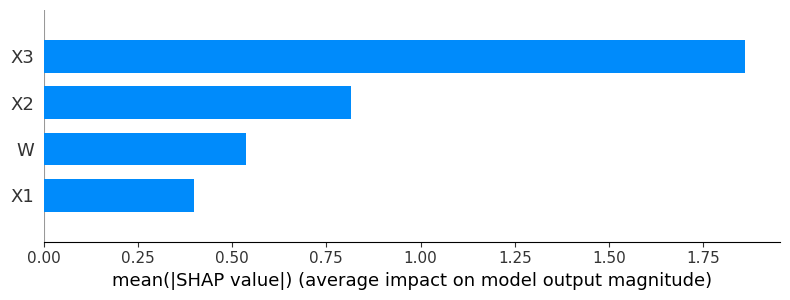

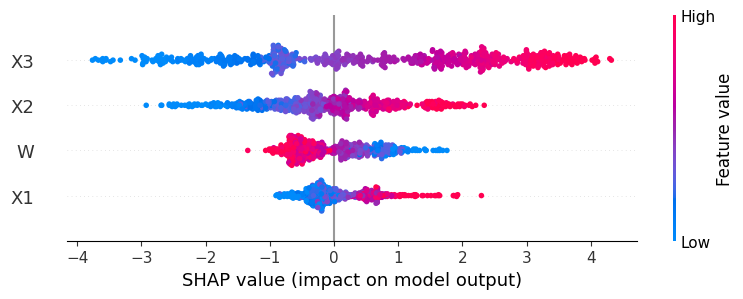

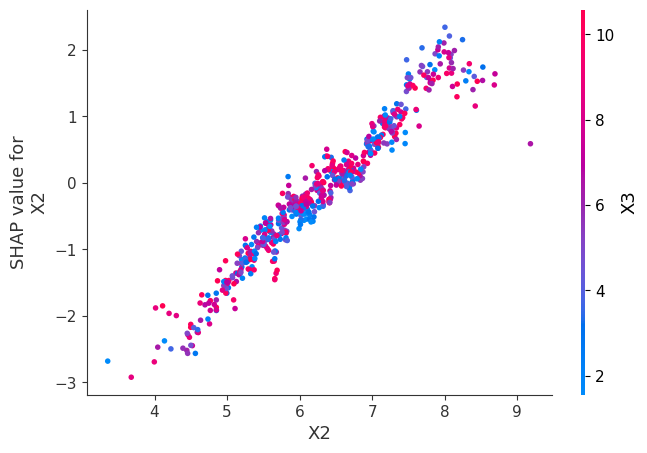

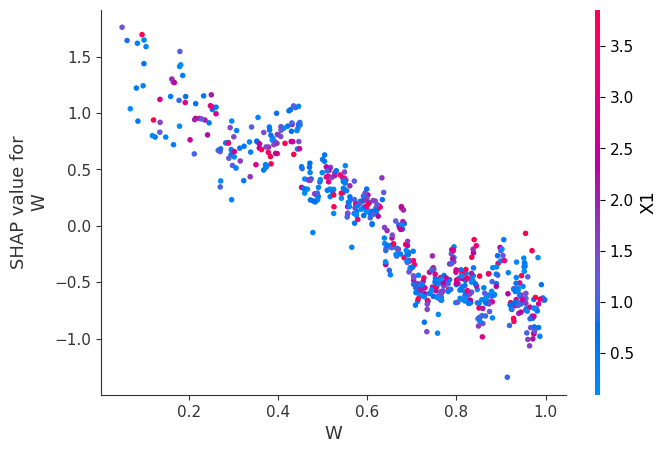

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import shap


# Features and target
feature_cols = ["W","X1","X2","X3"]
X = df[feature_cols]
y = df["Y"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost regressor (tune hyperparams as needed)
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"  # fast
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# performance
y_pred = model.predict(X_test)
print("Test R2:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# SHAP explainer (TreeExplainer for XGBoost)
explainer = shap.TreeExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)   # shape (n_samples, n_features)

# Global feature importance (mean absolute SHAP)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
imp_df = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": mean_abs_shap,
})
imp_df = imp_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
print(imp_df)

# Plots
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test, show=True)

# Dependence plot for X2 (important feature)
shap.dependence_plot("X2", shap_values, X_test, show=True)
shap.dependence_plot("W", shap_values, X_test, show=True)

X3 объявлена самой важной переменной! 

Вспоминаем, что ее истинный эффект +0.7, против эффекта X2 и W, которые равны +1.0 и -2.5 соответственно. Реальный порядок _каузальных эффектов_ W > X2 > X1. 

Между тем, W, самая важная _с казуальной точки зрения_ переменная, объявлена XGBoost + SHAP третьей по списку важности...

И это, заметим, при полной, правильной спецификации модели! 

(Но по крайней мере SHAP правильно уловил направления эффектов. W действительно снижает Y, и иксы действительно повышают Y.)

Однако, важность с каузальной точки зрения ≠ важность с предиктивной точки зрения.

Вспоминаем вариации признаков:

W      0.051639  

X1     1.888322  

X2     0.967638  

X3     8.603222  


W и X2 отодвинуты на задний план прежде всего по той причине, что они **мало варьируются**. 

Большая вариация + реальный каузальный эффект поставил X3 на первое место по важности, хотя **реальные каузальные сигналы сильнее у других переменных**.

Сюда же: SHAP оценивает вклад признака в предсказательную точность модели, а не его каузальный эффект !!! 
Вклад в предсказание <-> дисперсия признака, корреляция с другими признаками и функциональная форма признака.

Отсюда: хочешь оценить именно каузальные эффекты? Тогда не используй единичные (=S-model) предиктивные модели. И интерпретации не спасут.